# Sparse Hebbian Learning: toward a quantitative measure of the quality of filters

We are interested here in learning the "optimal" components of a set of images (let's say some "natural", usual images). As there is no supervisor to guide the learning, this is called unsupervised learning. Our basic hypothesis to find the best ("optimal") components will be to assume that *a priori* the most sparse is more plausible. We will implement the derived algorithm in this set of scripts.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import pandas as pd

## experiments

To test and control for the role of different parameters, we will have a first object (in the [shl_experiments.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_experiments.py) script) that controls a learning experiment. It contains all relevant parameters, but can also keep a trace of the history of some statistics. This is useful to compare the relative efficiency of the different solutions.


In [3]:
DEBUG_DOWNSCALE, verbose = 10, 0
DEBUG_DOWNSCALE, verbose = 1, 0
DEBUG_DOWNSCALE, verbose = 10, 10
DEBUG_DOWNSCALE, verbose = 1, 10

tag = 'independance'

eta_homeo = 0.1

nb_quant = 128
nb_quant = 256
C = 5.
homeo_methods = ['HEH', 'None']
alpha_homeo = 0.0

homeo_methods = ['HAP', 'None']
alpha_homeo = 0.2

n_iter = 2**13 + 1

record_num_batches = 2**12
N_show = 120
max_patches = 10
seed = 42
np.random.seed(seed)

opts = dict(DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, n_iter=n_iter, 
            eta_homeo=eta_homeo, alpha_homeo=alpha_homeo, 
            C=C, nb_quant=nb_quant, P_cum=None, verbose=verbose)

from shl_scripts.shl_experiments import SHL
shl = SHL(**opts)
data = shl.get_data(matname=tag)

Extracting data..No cache found data_cache/independance_data: Extracting data... Extracting data..Photo2018-01-18_0440462510.jpg, Photo2018-01-18_0309392473.jpg, Photo2018-01-18_0343102547.jpg, Photo2018-02-18_0911262631 square.jpg, Photo2018-01-18_0327052545.jpg, Photo2018-01-18_0440352508.jpg, Photo2018-01-18_0230432458.jpg, Photo2018-01-18_0316462527.jpg, Photo2018-01-18_0553172551.jpg, Photo2018-01-18_0423102502.jpg, Photo2018-01-18_0422432500.jpg, Photo2018-01-18_0441022511.jpg, Data is of shape : (262140, 144) - done in 117.41s.
Data is of shape : (262140, 144) - done in 118.34s.


In [4]:
!ls -l {shl.data_cache}/{tag}*
!rm -fr {shl.data_cache}/{tag}*lock*

-rw-r--r--  1 laurentperrinet  staff  301985408 Feb 23 16:01 data_cache/independance_data.npy


In [5]:
print('number of patches, size of patches = ', data.shape)
print('average of patches = ', data.mean(), ' +/- ', data.mean(axis=1).std())
SE = np.sqrt(np.mean(data**2, axis=1))
print('average energy of data = ', SE.mean(), '+/-', SE.std())

number of patches, size of patches =  (262140, 144)
average of patches =  1.4578306989484052e-05  +/-  0.006638689828201611
average energy of data =  0.029647154513547106 +/- 0.03759209103599952


In [6]:
stick = np.arange(shl.n_dictionary)*nb_quant

indx = np.random.permutation(data.shape[0])[:record_num_batches]
P_cum_zeroeffect = np.linspace(0, 1, nb_quant, endpoint=True)[np.newaxis, :] * np.ones((shl.n_dictionary, 1))


## learning

The actual learning is done in a second object (here ``dico``) from which we can access another set of properties and functions  (see the [shl_learn.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_learn.py) script):

No cache found data_cache/independance_HAP_dico.pkl: Learning the dictionary with algo = mp 
 Training on 262140 patches
Iteration   1 /   8193 (elapsed time:   2s,   0mn   2s)
Iteration  129 /   8193 (elapsed time:  87s,   1mn  27s)
Iteration  257 /   8193 (elapsed time:  175s,   2mn  55s)
Iteration  385 /   8193 (elapsed time:  288s,   4mn  48s)
Iteration  513 /   8193 (elapsed time:  402s,   6mn  42s)
Iteration  641 /   8193 (elapsed time:  506s,   8mn  26s)
Iteration  769 /   8193 (elapsed time:  607s,  10mn   7s)
Iteration  897 /   8193 (elapsed time:  702s,  11mn  42s)
Iteration  1025 /   8193 (elapsed time:  804s,  13mn  24s)
Iteration  1153 /   8193 (elapsed time:  896s,  14mn  56s)
Iteration  1281 /   8193 (elapsed time:  1001s,  16mn  41s)
Iteration  1409 /   8193 (elapsed time:  1096s,  18mn  16s)
Iteration  1537 /   8193 (elapsed time:  1198s,  19mn  58s)
Iteration  1665 /   8193 (elapsed time:  1294s,  21mn  34s)
Iteration  1793 /   8193 (elapsed time:  1397s,  23mn  17s)


Iteration  8193 /   8193 (elapsed time:  9774s,  162mn  54s)
done (total time:  9775s,  162.9mn)
done in 9775.07s.
size of dictionary = (number of filters, size of imagelets) =  (529, 144)
average of filters =  -0.00013056542549670357 +/- 0.009832422578213445
average energy of filters =  1.0 +/- 8.539934949036291e-17


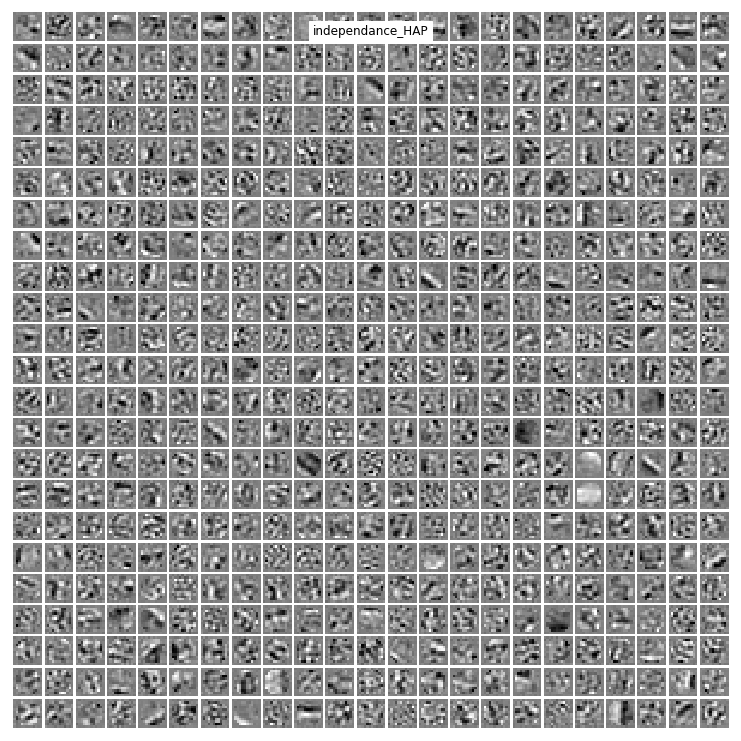

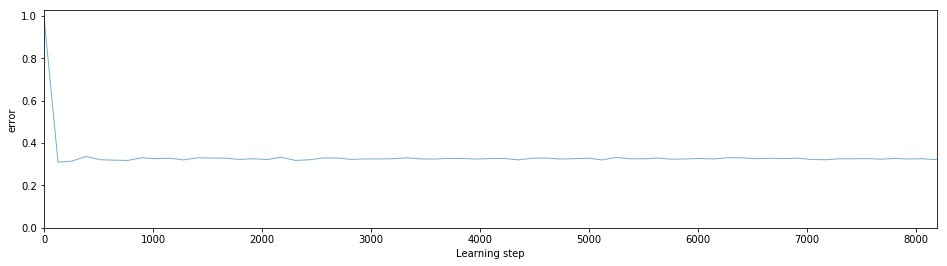

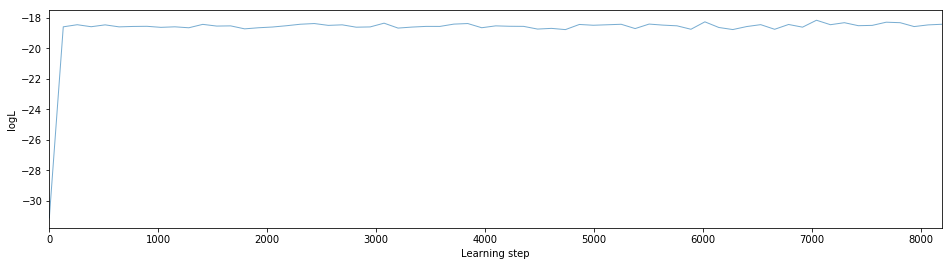

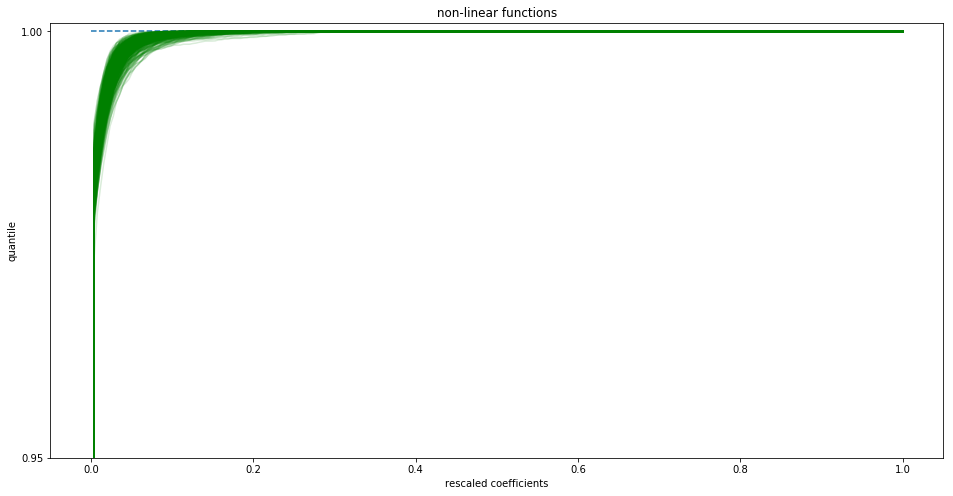

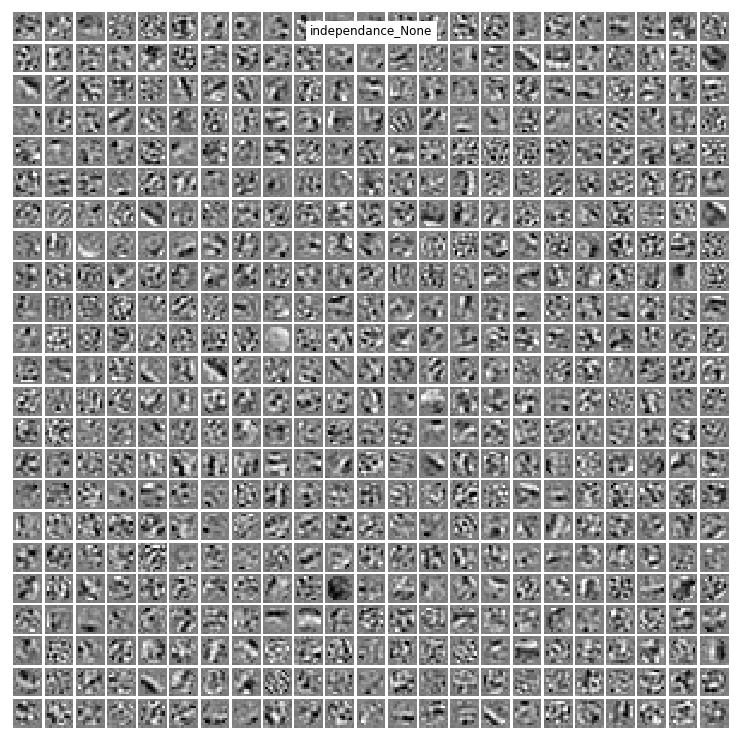

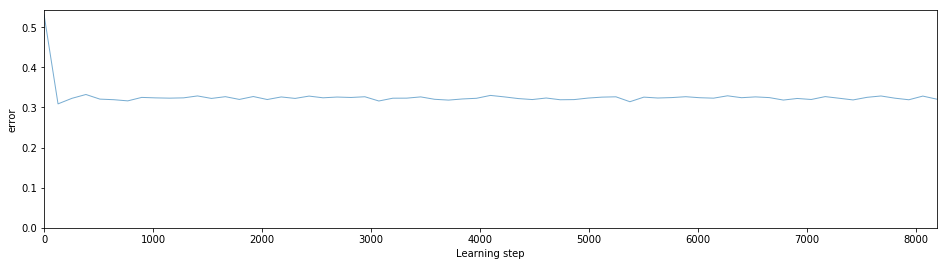

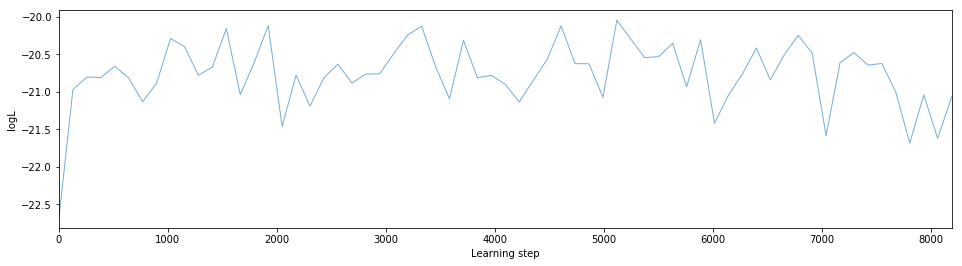

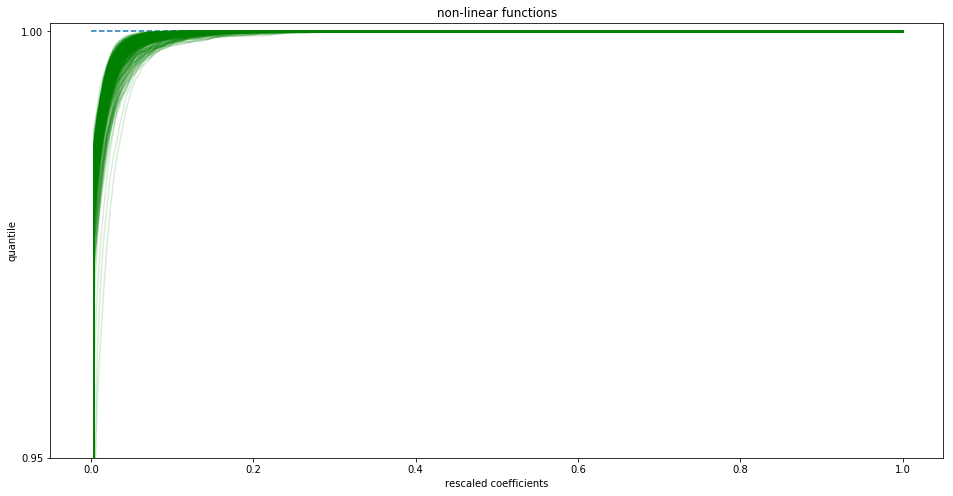

In [7]:
list_figures = ['show_dico', 'time_plot_error', 'time_plot_logL']

dico = {}
for homeo_method in homeo_methods:
    shl = SHL(homeo_method=homeo_method, **opts)
    dico[homeo_method] = shl.learn_dico(data=data, list_figures=list_figures, matname=tag + '_' + homeo_method)

    print('size of dictionary = (number of filters, size of imagelets) = ', dico[homeo_method].dictionary.shape)
    print('average of filters = ',  dico[homeo_method].dictionary.mean(axis=1).mean(), 
          '+/-',  dico[homeo_method].dictionary.mean(axis=1).std())
    SE = np.sqrt(np.sum(dico[homeo_method].dictionary**2, axis=1))
    print('average energy of filters = ', SE.mean(), '+/-', SE.std())

    if not dico[homeo_method].P_cum is None: 
        from shl_scripts.shl_tools import plot_P_cum
        fig, ax = plot_P_cum(dico[homeo_method].P_cum, verbose=False, alpha=.15);
        ax.set_ylim(0.95, 1.001)
        #ax.set_xmargin(0.);

## theory



Sum of non-zero coefficients 61350 ~= 61440
average non-zeros 115.97353497164461 ~= 116.14366729678639


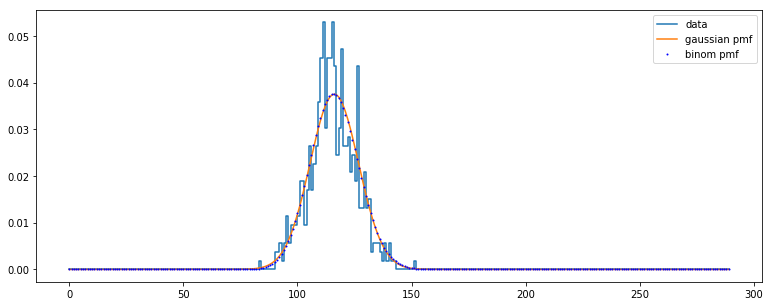

In [8]:
from scipy.stats import binom
# define the mean
rho = shl.l0_sparseness / shl.n_dictionary

# draw binomial samples
sparse_code_binary = np.random.rand(record_num_batches, shl.n_dictionary) > 1 - rho

# define the theoretical standard deviation
sd = np.sqrt(rho*(1-rho)*record_num_batches)

# the binomial probability is defined from 0 to record_num_batches \times shl.n_dictionary
# for visualization, we show the part around non-zero probabilities:
#record_num_batches_high = int(rho * record_num_batches + 15. * sd)
record_num_batches_high = int(2.5 * rho * record_num_batches)
bins = np.arange(record_num_batches_high)

print('Sum of non-zero coefficients', sparse_code_binary.sum(), '~=', shl.l0_sparseness*record_num_batches)
print('average non-zeros', np.count_nonzero(sparse_code_binary, axis=0).mean(), '~=', rho*record_num_batches)
fig, ax= plt.subplots(figsize=(13, 5))
smarts, edges = np.histogram(np.count_nonzero(sparse_code_binary, axis=0), density=True, bins=bins)
smarts /= smarts.sum()
ax.step(edges, np.hstack((smarts, 0)), where='pre', label='data');
#edges_mid = .5*( edges[1:] + edges[:-1] )
#print(rho, s, edges)
proba = np.exp(-.5 * (edges - rho*record_num_batches)**2 / sd**2)
proba /= proba.sum()
ax.plot(edges, proba, label='gaussian pmf');
proba_binom = binom.pmf(edges, record_num_batches, rho)
proba_binom /= proba_binom.sum()
ax.plot(edges, proba_binom, 'bo', ms=1, label='binom pmf')
ax.legend()

In [9]:
def get_logL(sparse_code):
    record_num_batches = sparse_code.shape[0]
    rho_hat = np.count_nonzero(sparse_code_binary, axis=0).mean()/record_num_batches
    #rho = shl.l0_sparseness / shl.n_dictionary
    sd = np.sqrt(rho_hat*(1-rho_hat)*record_num_batches)

    measures = np.count_nonzero(sparse_code, axis=0)

    # likelihood = 1 / np.sqrt(2*np.pi) / sd *  np.exp(-.5 * (measures - rho)**2 / sd**2)
    logL = -.5 * (measures - rho_hat*record_num_batches)**2 / sd**2
    logL -= np.log(np.sqrt(2*np.pi) * sd)
    #print(np.log(np.sum(np.exp(logL))), np.log(np.sqrt(2*np.pi) * sd))
    #logL -= np.log(np.sum(np.exp(logL)))
    return logL
    

In [10]:
rho = shl.l0_sparseness / shl.n_dictionary
sd = np.sqrt(rho*(1-rho)*record_num_batches)

for _ in range(10):
    sparse_code_binary = np.random.rand(record_num_batches, shl.n_dictionary) > 1 - rho
    logL = get_logL(sparse_code_binary)
    print ('log-likelihood for random sample=', logL.mean(), '+/-', logL.std())


log-likelihood for random sample= -3.794891849475215 +/- 0.761200516679525
log-likelihood for random sample= -3.788604200092681 +/- 0.6275751653240056
log-likelihood for random sample= -3.7927156606157824 +/- 0.7932229552647169
log-likelihood for random sample= -3.789564209738831 +/- 0.7202968956661745
log-likelihood for random sample= -3.7802196424391408 +/- 0.7683810682905842
log-likelihood for random sample= -3.809622097423578 +/- 0.7200900096889922
log-likelihood for random sample= -3.761731291738489 +/- 0.6486163705716061
log-likelihood for random sample= -3.7892392486529287 +/- 0.6825275057241655
log-likelihood for random sample= -3.7719663978096576 +/- 0.7258302991618447
log-likelihood for random sample= -3.814777313932573 +/- 0.7079623803776643


## coding

The learning itself is done via a gradient descent but is highly dependent on the coding / decoding algorithm. This belongs to a another function (in the [shl_encode.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_encode.py) script)

In [11]:
from shl_scripts.shl_tools import show_data
def print_stats(data, dictionary, sparse_code):
    print(42*'🐒')

    print('number of codes, size of codewords = ', sparse_code.shape)
    print('average of codewords = ', sparse_code.mean())
    print('average std of codewords = ', sparse_code.std())
    print('l0-sparseness of codewords = ', (sparse_code>0).mean(), ' ~= l0/M =', shl.l0_sparseness/shl.n_dictionary)
    print('std of the average of individual patches = ', sparse_code.mean(axis=0).std())


    plt.matshow(sparse_code[:N_show, :])
    plt.show()
    fig, axs = show_data(data[:max_patches, :])
    plt.show()

    patches = sparse_code @ dictionary
    error = data - patches
    
    print('number of codes, size of reconstructed images = ', patches.shape)

    fig, axs = show_data(patches[:max_patches, :])
    plt.show()
    fig, axs = show_data(error[:max_patches, :], cmax=np.max(np.abs(patches[:max_patches, :])))
    plt.show()
    print('average of data patches = ', data.mean(), '+/-', data.mean(axis=1).std())
    print('average of residual patches = ', error.mean(), '+/-', error.mean(axis=1).std())
    SD = np.sqrt(np.mean(data**2, axis=1))

    print('median energy of data = ', np.median(SD))
    print('average energy of data = ', SD.mean(), '+/-', SD.std())
    
    SE = np.sqrt(np.mean(error**2, axis=1))

    print('average energy of residual = ', SE.mean(), '+/-', SE.std())
    print('median energy of residual = ', np.median(SE))
    print('average gain of coding = ', (SD/SE).mean(), '+/-', (SD/SE).std())
    
    return SD, SE

In [12]:
homeo_methods

['HAP', 'None']

🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (4096, 529)
average of codewords =  0.0022051120830010743
average std of codewords =  0.02330272234243846
l0-sparseness of codewords =  0.028147706462665407  ~= l0/M = 0.02835538752362949
std of the average of individual patches =  0.0017389252445049487


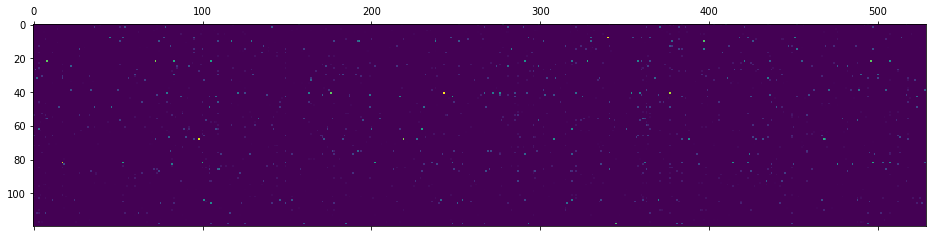

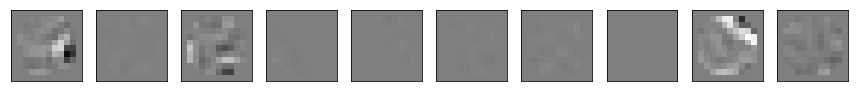

number of codes, size of reconstructed images =  (4096, 144)


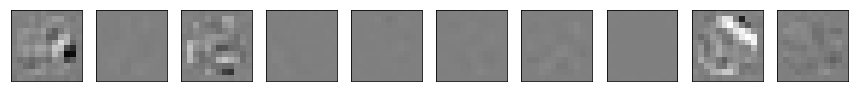

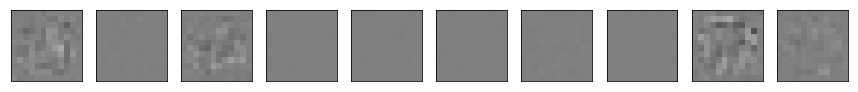

average of data patches =  -7.100443737628172e-05 +/- 0.006574908718507028
average of residual patches =  -0.00019679316517579607 +/- 0.0015926239105766874
median energy of data =  0.01805433222943249
average energy of data =  0.030413328139507825 +/- 0.03819488457404461
average energy of residual =  0.012197186044799307 +/- 0.015195847321285455
median energy of residual =  0.008134666510101043
average gain of coding =  3.1476132774330265 +/- 1.6232498239772566
🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (4096, 529)
average of codewords =  0.002227347225845315
average std of codewords =  0.023326848182956085
l0-sparseness of codewords =  0.028253854560491492  ~= l0/M = 0.02835538752362949
std of the average of individual patches =  0.0015939276613823343


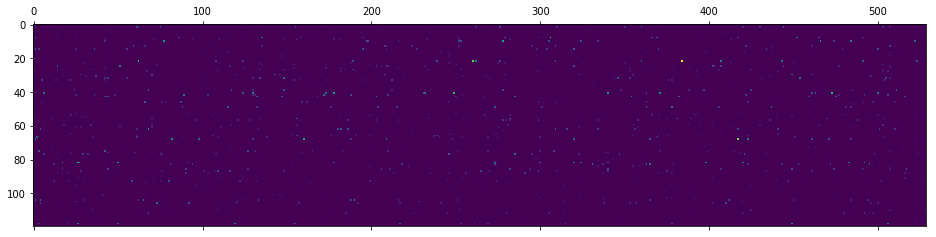

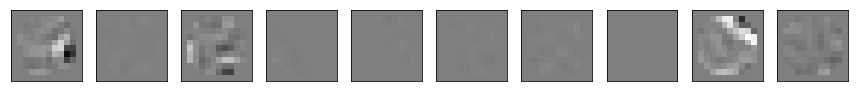

number of codes, size of reconstructed images =  (4096, 144)


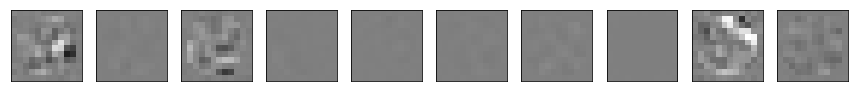

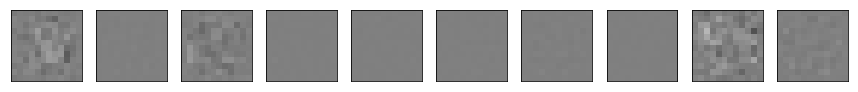

average of data patches =  -7.100443737628172e-05 +/- 0.006574908718507028
average of residual patches =  -3.865865073078613e-05 +/- 0.0021781395331548783
median energy of data =  0.01805433222943249
average energy of data =  0.030413328139507825 +/- 0.03819488457404461
average energy of residual =  0.012096043745385207 +/- 0.015095635940019576
median energy of residual =  0.007946359341238104
average gain of coding =  2.9175958778155984 +/- 1.0582034405449163


In [13]:
from shl_scripts.shl_encode import sparse_encode
sparse_code = {}
for homeo_method in homeo_methods:
    if dico[homeo_method].P_cum is None: 
        gain = np.ones(shl.n_dictionary)
    else:
        gain = None
    sparse_code[homeo_method] = sparse_encode(data[indx, :], dico[homeo_method].dictionary, 
                                 P_cum=dico[homeo_method].P_cum, l0_sparseness = shl.l0_sparseness, C=C, gain=gain)
    SD, SE = print_stats(data[indx, :], dico[homeo_method].dictionary, sparse_code[homeo_method])

In [14]:
sparse_code[homeo_method].shape

(4096, 529)

Average of non-zero coefficients 0.028147706462665407 ~= 0.02835538752362949
Mean of non-zero coefficients 115.29300567107751 ~= 116.14366729678639
Mean of non-zero coefficients 115.29300567107751 +/- 106.42563174750856
Median of non-zero coefficients 86.0
Average of non-zero coefficients 0.028253854560491492 ~= 0.02835538752362949
Mean of non-zero coefficients 115.72778827977315 ~= 116.14366729678639
Mean of non-zero coefficients 115.72778827977315 +/- 77.35119626932371
Median of non-zero coefficients 97.0


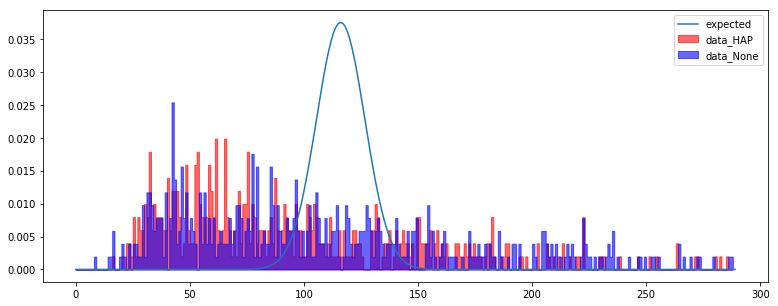

In [15]:
rho = shl.l0_sparseness / shl.n_dictionary
sd = np.sqrt(rho*(1-rho)*record_num_batches)

fig, ax= plt.subplots(figsize=(13, 5))
for homeo_method, color in zip(homeo_methods, ['r', 'b']):
    print('Average of non-zero coefficients', (sparse_code[homeo_method]>0).mean(), '~=', rho)
    n_i = np.count_nonzero(sparse_code[homeo_method], axis=0)
    print('Mean of non-zero coefficients', n_i.mean(), '~=', rho*record_num_batches)
    print('Mean of non-zero coefficients', n_i.mean(), '+/-', n_i.std())
    print('Median of non-zero coefficients', np.median(n_i))
    smarts, edges = np.histogram(n_i, density=True, bins=bins)
    smarts /= smarts.sum()
    # ax.step(edges, np.hstack((smarts, 0)), where='pre', label='data_' + homeo_method);
    ax.fill_between(edges[:-1], smarts, step='pre', label='data_' + homeo_method, alpha=.6, color=color);

proba = 1 / np.sqrt(2*np.pi) / sd *  np.exp(-.5 * (edges - rho*record_num_batches)**2 / sd**2)
#proba /= proba.sum()
ax.plot(edges, proba, label='expected')
ax.legend();

In [16]:
rho, sparse_code[homeo_method].mean(), homeo_methods

(0.02835538752362949, 0.002227347225845315, ['HAP', 'None'])

## measuring the distance to independance 

In [17]:
#fig, ax= plt.subplots(figsize=(13, 5))
for homeo_method in homeo_methods:
    logL = get_logL(sparse_code[homeo_method])
    print ('log-likelihood for homeo_method=', homeo_method, 'is', logL.mean(), '+/-', logL.std())
    #ax.vline(edges, proba, label=homeo_method)

logL = get_logL(np.random.rand(record_num_batches, shl.n_dictionary) > 1 - rho)
print ('log-likelihood for theory=', homeo_method, 'is', logL.mean(), '+/-', logL.std())
#for _ in range(10):
#    logL = get_logL(np.random.rand(record_num_batches, shl.n_dictionary) > 1 - rho)
#ax.plot(edges, proba, label='theory')
#ax.legend();

log-likelihood for homeo_method= HAP is -53.236787141662056 +/- 231.3390622005142
log-likelihood for homeo_method= None is -29.671453595057084 +/- 60.42424705117982
log-likelihood for theory= None is -3.8508657581208214 +/- 0.8351947610555182


## Version used

In [18]:
%load_ext version_information
%version_information numpy, shl_scripts, pandas

Software versions
Python 3.6.4 64bit [GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.39.2)]
IPython 6.2.1
OS Darwin 17.4.0 x86_64 i386 64bit
numpy 1.14.1
shl_scripts 20171221
pandas 0.22.0
Fri Feb 23 20:33:00 2018 CET